# Continuous Rank Probability Score (CRPS) for Uncertainty Prediction
The CRPS was originally used to compare deterministic and probabilistic predictions and to evaluate probabilistic forecasts (Matheson and Winkler, 1976; Hersbach, 2000; Gneiting and Raftery, 2007).  It can be viewed as the mean absolute error for multiple equally likely predictions and is expressed as
$$CRPS(F,y_{true}) = \int_{-\infty}^{\infty} \left(F(y_{pred}) - \mathcal{H}(y_{pred} - y_{true})\right)^2 dy ,$$

where $F$ is the predicted <b>cumulative density function</b> (CDF), $y_{pred}$ is the predicted value, $y_{true}$ is the observed value, and $\mathcal{H}$ is the Heaviside step function given by
$$\mathcal{H}:= 1, (y_{pred} - y_{true}) \ge 0, $$ \
$$\;\;\;  := 0, (y_{pred} - y_{true}) < 0. $$ \

That is, $\mathcal{H}$ is 1 if the predicted error is positive and 0 if the error is negative.  Thus, the CRPS is essentially the error between the predicted CDF, $F(y_{pred})$, and the observed CDF, $\mathcal{H}(y_{pred} - y_{true})$.

\
Recently, the CRPS has been implemented in the loss function for training neural networks for ensemble weather forecasting (Rasp and Lerch, 2018; Scher and Messori, 2020; Gr$\mathrm{\ddot{o}}$nquist et al., 2021).  Brey (2021) provides an excellent demonstration for using the CRPS as a loss function and is the basis of this notebook.  In this implementation, the ensemble members can be added into the neural network architecture so that the model can be trained for the optimal distribution of ensemble members, removing the requirement of an *a priori* uncertainty distribution.

<br> Contact: <br>
Kathy Haynes (katherine.haynes@colostate.edu) <br>
Cooperative Institute for Research in the Atmosphere (CIRA) <br>
June 2022


## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

!pip install properscoring
from properscoring import crps_ensemble

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Loss Function
The loss function for CRPS is based on the identity
$$CRPS^*(\hat{Y}, y_{true}) = E_{F}\vert\hat{Y} - y_{true}\vert - \frac{1}{2} \; E_{F}\vert\hat{Y} - \hat{Y}'\vert,$$ \
where $CRPS^*$ is the negative orientation of $CRPS$, $\hat{Y}$ is a randomly-drawn sample of the distribution of $y_{pred}$, $\hat{Y}'$ is a transposed copy of $\hat{Y}$, and $E_F$ is the expected value function.  The left hand term corresponds to the mean absolute error between the neural network predictions and the actual $y_{true}$.  The right hand term corresponds to one half of the predicted spread, or the mean absolute value of the pairwise differences between the different ensemble members.

In [ ]:
def loss_crps_sample_score(y_true, y_pred):
    """Calculates the Continuous Ranked Probability Score (CRPS)
    for finite ensemble members and a single target.
    
    This implementation is based on the identity:
        CRPS(F, x) = E_F|y_pred - y_true| - 1/2 * E_F|y_pred - y_pred'|
    where y_pred and y_pred' denote independent random variables drawn from
    the predicted distribution F, and E_F denotes the expectation
    value under F.

    Following the approach by Steven Brey at 
    TheClimateCorporation (formerly ClimateLLC)
    https://github.com/TheClimateCorporation/properscoring
    
    Adapted from David Blei's lab at Columbia University
    http://www.cs.columbia.edu/~blei/ and
    https://github.com/blei-lab/edward/pull/922/files

    
    References
    ---------
    Tilmann Gneiting and Adrian E. Raftery (2005).
        Strictly proper scoring rules, prediction, and estimation.
        University of Washington Department of Statistics Technical
        Report no. 463R.
        https://www.stat.washington.edu/research/reports/2004/tr463R.pdf
    
    H. Hersbach (2000).
        Decomposition of the Continuous Ranked Probability Score
        for Ensemble Prediction Systems.
        https://doi.org/10.1175/1520-0434(2000)015%3C0559:DOTCRP%3E2.0.CO;2
    """

    # Variable names below reference equation terms in docstring above
    term_one = tf.reduce_mean(tf.abs(
        tf.subtract(y_pred, y_true)), axis=-1)
    term_two = tf.reduce_mean(
        tf.abs(
            tf.subtract(tf.expand_dims(y_pred, -1),
                        tf.expand_dims(y_pred, -2))),
        axis=(-2, -1))
    half = tf.constant(-0.5, dtype=term_two.dtype)
    score = tf.add(term_one, tf.multiply(half, term_two))
    score = tf.reduce_mean(score)
    return score

## Model Architecture
The model architecture is a fully-connected neural network that outputs ensemble members representing estimates of the target values.

In [ ]:
def build_crps_network(
        input_shape=1,
        n_members=50,
        neurons=100,
        output_activation='linear',
        model_name="crps_model",
        learn_rate=0.001,
        compile_model=True,
        clear_session=True):
    ###
    # Build a simple neural network that creates an ensemble of 
    # predictions using the CRPS loss.
    ###
    # Inputs:
    # input_shape (int): number of features for training
    # n_members (int): number of ensemble members to estimate target.
    # neurons (int): number of nodes in each hidden layer
    # model_name (str): name of model
    # learn_rate (float): learning rate of model
    # compile_model (bool): compile model before returning?
    # clear_session (bool): clear the tensorflow session?
    #
    # Outputs:
    # tensorflow.keras.Model
    #
    if clear_session:
        tf.keras.backend.clear_session()

    # create features
    inputs = Input(shape=(input_shape,), name="Input")

    # create three hidden layers
    x = Dense(neurons, activation=tf.nn.leaky_relu, name="L1")(inputs)
    x = Dense(neurons, activation=tf.nn.leaky_relu, name="L2")(x)
    x = Dense(neurons, activation=tf.nn.leaky_relu, name="L3")(x)

    # create ensembles
    outputs = Dense(n_members,
                    activation=output_activation, 
                    name="Ensemble_Members")(x)
    
    # create model
    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    
    # Compile model, if desired
    if compile_model:
        opt = Adam(learning_rate=learn_rate)
        model.compile(loss=loss_crps_sample_score, optimizer=opt)
    return model

## Synthetic Data
In order to create a dataset with disparate target pathways, we will use a gamma distribution and replace some of the values with a point mass distribution, where the targets are constant regardless of the input.

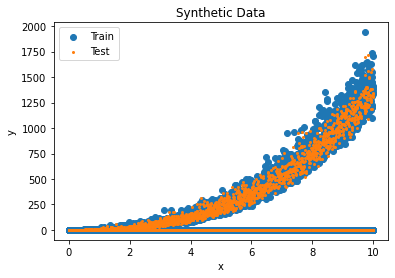

In [ ]:
N = 10000  # number of samples
x_min = 0  # minimimum value of x
x_max = 10 # maximum value of x

# Create x-values using a random uniform distribution
x_values = np.float32(np.random.uniform(x_min, x_max, N))

# Create y-values using a gamma distribution
r_gamma = np.array([np.random.gamma(shape=i, scale=i) for i in x_values])
y_values = np.float32(np.power(x_values, 3) + r_gamma * 4.0)

# Replace some of our y values with point mass data
point_mass_frac = 0.5  # how much of y to replace with point mass data
point_mass_val = 0     # replacement value of y
n_pointmass = int(point_mass_frac * N)
replace_ind = np.random.randint(0, N, n_pointmass)
y_values[replace_ind] = point_mass_val

# Split data into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x_values, y_values, test_size=0.3, random_state=10, 
    shuffle=True)

plotData = True
if plotData:
    fig1, ax1 = plt.subplots(1, 1)
    ax1.scatter(x_train, y_train, label='Train')
    ax1.scatter(x_test, y_test, label='Test', s=4)
    ax1.legend()
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Synthetic Data')

## Perform Experiment
Here we will create a neural network model using the CRPS as the loss function, and train it on the sample dataset.

In [ ]:
# Build and train the model
n_ensembles = 30
crps_net = build_crps_network(n_members=n_ensembles)
crps_net.summary()

monitor = EarlyStopping(monitor='val_loss',
                         min_delta=0.0, patience=4, verbose=1,
                         mode='auto', restore_best_weights=True)
crps_net.fit(x=x_train, y=y_train, 
             batch_size=128,
             callbacks=[monitor],
             epochs=100,
             validation_data=(x_test, y_test),
             verbose=1)

Model: "crps_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1)]               0         
                                                                 
 L1 (Dense)                  (None, 100)               200       
                                                                 
 L2 (Dense)                  (None, 100)               10100     
                                                                 
 L3 (Dense)                  (None, 100)               10100     
                                                                 
 Ensemble_Members (Dense)    (None, 30)                3030      
                                                                 
Total params: 23,430
Trainable params: 23,430
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
55/55 [==============================] -

In evaluating the model, we see the the mean CRPS score across all of the model ensemble members is the same as that calculated in the loss function.

In [ ]:
# Evaluate the model
crps_loss = crps_net.evaluate(x_test, y_test)
y_pred = crps_net.predict(x_test)
crps_score = crps_ensemble(y_test, y_pred)
print("Model Loss: {:.4f}".format(crps_loss))
print("Mean Model CRPS Score: {:.4f}".format(crps_score.mean()))


94/94 [==============================] - 0s 2ms/step - loss: 101.7330
Model Loss: 101.7330
Mean Model CRPS Score: 101.7330


Finally, we can use the model to create predictions over a range of values.  Using the same range of input values as what we trained on, we can plot both the test data and the predictions from all of the ensemble members.  In the resulting figure, we see that ensemble members represent both the range of target values for the gamma distribution as well as the constant target values in the point distribution.  For datasets such as this with disparate target values, using the CRPS loss function to create ensemble members does a good job at representing the data and providing a distribution which can then be used for uncertainty estimates.  

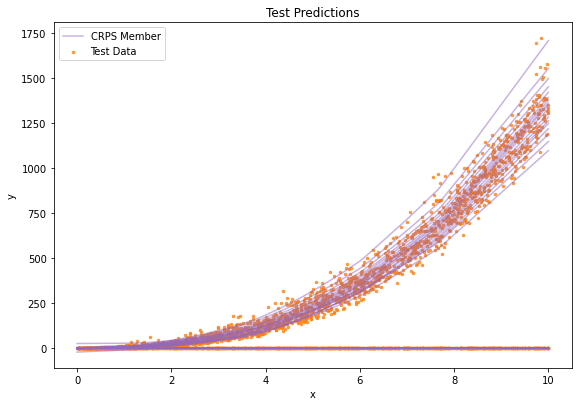

In [ ]:
# Create continuous predictions
x_span = np.expand_dims(np.linspace(x_min, x_max, 1000), 1)
ypred_span = crps_net.predict(x_span)

plotPredictions = True
if plotPredictions:
  fig = plt.figure()
  ax = fig.add_axes([0, 0, 1.2, 1.2])
  
  for i_ens in np.arange(0, n_ensembles):
    if i_ens == 0:
      ax.plot(x_span, ypred_span[:, i_ens],
              alpha=0.5, color='tab:purple',
              label="CRPS Member")
    else:
      ax.plot(x_span, ypred_span[:, i_ens],
              alpha=0.5,
              color='tab:purple')

  ax.scatter(x_test,  y_test, 
             alpha=0.75, color='tab:orange',
             label="Test Data", s=6)

  ax.legend()
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_title("Test Predictions")


## References and Additional Information

Brey, S.J., 2021: A package for making and working with probabilistic predictions.  Github, https://github.com/TheClimateCorporation/ensemble/. \
Dai, Y. and S. Hemri, 2021: Spatially coherent postprocessing of cloud cover forecasts using generative adversarial networks.  *EGU General Assembly 2021*, online, 19-30 Apr 2021, EGU21-4374, https://doi.org/10.5194/egusphere-egu21-4374. \
Gr$\mathrm{\ddot{o}}$nquist, P., C. Yao, T. Ben-Nun, N. Dryden, P. Dueben, S. Li, and T. Hoefler, 2021: Deep learning for post-processing ensemble weather forecasts.  *Phil. Trans. R. Soc. A.*, <b>379</b>, https://doi.org/10.1098/rsta.2020.0092. \
Gneiting, T. and A.E. Raftery, 2007: Strictly proper scoring rules, prediction, and estimation. *J. Amer. Statistical Assoc.*, <b>102</b>, 359-378, https://doi.org/10.1198/016214506000001437. \
Hersbach, H., 2000:  Decomposition of the continuous ranked probability score for ensemble prediction systems.  *Weather and Forecasting*, <b>15</b>, 559-570, [https://doi.org/10.1175/1520-0434(2000)015<0559:DOTCRP>2.0.CO;2](https://journals.ametsoc.org/configurable/content/journals$002fwefo$002f15$002f5$002f1520-0434_2000_015_0559_dotcrp_2_0_co_2.xml?t:ac=journals%24002fwefo%24002f15%24002f5%24002f1520-0434_2000_015_0559_dotcrp_2_0_co_2.xml). \
Rasp, S. and S. Lerch, 2018: Neural Networks for postprocessing ensemble weather forecasts.  *Monthly Weather Review*, <b>146</b>, 3885-3900, https://doi.org/10.1175/MWR-D-18-0187.1. \
Scher, S. and G. Messori, 2020: Ensemble methods for neural network-based weather forecasts.  *J. Advances in Modeling Earth Systems*, <b>13</b>, https://doi.org/10.1029/2020MS002331. \